<a href="https://colab.research.google.com/github/JackGraymer/Face-Recognition/blob/main/face_recognition_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition - Model Evaluation

## Introduction

Face recognition is a fundamental task in computer vision with applications ranging from personal device authentication to large-scale surveillance systems. In recent years, the field has witnessed significant advancements due to the development of deep learning architectures and the availability of large annotated datasets.

Big tech companies have been at the forefront of deploying high-performance face recognition systems:

* **Google** introduced *FaceNet*, which maps faces into a compact Euclidean space and achieves >99% accuracy on benchmarks like LFW (Labeled Faces in the Wild).
* **Facebook** developed *DeepFace*, one of the first deep learning face systems to surpass human-level accuracy.
* **Apple** and **Microsoft** use proprietary models optimized for real-time face verification and authentication in constrained environments (e.g., mobile devices).
* **Open-source models** like *VGGFace*, *ArcFace*, and *Dlib* continue to be widely used for research and production purposes.

Despite these advances, building and evaluating face recognition models remains a challenging task—especially when considering smaller, less curated datasets or when generalizing to new identities.

## Project Objective

This project aims to **evaluate and compare different deep learning models** for face recognition on a curated dataset of **17 celebrities**, each with **100 images** from [Celebrity Face Image Dataset (Kaggle)](https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset/data). The goals are:

* To understand how different pre-trained architectures (VGG16, etc.) perform on a face classification task.
* To analyze model generalization, overfitting behavior, and performance trade-offs.
* To develop a reproducible framework for face recognition using standard metrics like accuracy, confusion matrices, and training curves.

---

## Why This Matters

While industry systems benefit from massive datasets and optimized hardware, academic and small-scale applications must often rely on pre-trained models and modest data. This project offers:

* A hands-on exploration of model evaluation under realistic constraints.
* Insights into fine-tuning and transfer learning strategies.
* A foundation for deploying real-world face recognition systems in low-resource settings.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG16
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2

# Variables
original_dataset_folder = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Celebrity Faces Dataset"  # Folder path containing class subdirectories
augmented_dataset_folder = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces"  # Folder path containing class subdirectories
models_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/models"  # Folder path to save models
image_size = (128, 128)  # Image size
batch_size = 32  # Batch size
epochs = 30  # Number of epochs for training

In [4]:
import os
import numpy as np
import cv2
import tensorflow as tf

def load_dataset(dataset_folder, image_size):
    data, labels, classes = [], [], []
    valid_extensions = ('.jpg', '.jpeg', '.png')

    for idx, class_dir in enumerate(sorted(os.listdir(dataset_folder))):
        class_path = os.path.join(dataset_folder, class_dir)
        if os.path.isdir(class_path):
            classes.append(class_dir)
            for img_file in os.listdir(class_path):
                if not img_file.lower().endswith(valid_extensions):
                    continue
                img_path = os.path.join(class_path, img_file)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Warning: could not read image {img_path}")
                        continue
                    img = cv2.resize(img, image_size)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    data.append(img)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")

    data = np.array(data, dtype='float32') / 255.0
    labels = np.array(labels)
    return data, labels, classes

# Save/load paths
original_npz_path = os.path.join(original_dataset_folder, "original_data.npz")
augmented_npz_path = os.path.join(augmented_dataset_folder, "augmented_data.npz")

# Load or process original dataset
if os.path.exists(original_npz_path):
    print(f"Loading original data from: {original_npz_path}")
    original = np.load(original_npz_path)
    original_data, original_labels = original['data'], original['labels']
    original_classes = sorted(os.listdir(original_dataset_folder))
else:
    print("Processing original dataset...")
    original_data, original_labels, original_classes = load_dataset(original_dataset_folder, image_size)
    np.savez(original_npz_path, data=original_data, labels=original_labels)

# Load or process augmented dataset
if os.path.exists(augmented_npz_path):
    print(f"Loading augmented data from: {augmented_npz_path}")
    augmented = np.load(augmented_npz_path)
    augmented_data, augmented_labels = augmented['data'], augmented['labels']
    augmented_classes = sorted(os.listdir(augmented_dataset_folder))
else:
    print("Processing augmented dataset...")
    augmented_data, augmented_labels, augmented_classes = load_dataset(augmented_dataset_folder, image_size)
    np.savez(augmented_npz_path, data=augmented_data, labels=augmented_labels)

# Display info
print(f"Original dataset: {len(original_data)} images across {len(original_classes)} classes → {original_classes}")
print(f"Augmented dataset: {len(augmented_data)} images across {len(augmented_classes)} classes → {augmented_classes}")


Loading original data from: /content/drive/MyDrive/Colab Notebooks/Computer Vision/Celebrity Faces Dataset/original_data.npz
Loading augmented data from: /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/augmented_data.npz
Original dataset: 2197 images across 19 classes → ['Alvaro Cervan', 'Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith', 'original_data.npz']
Augmented dataset: 8788 images across 20 classes → ['Alvaro Cervan', 'Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith', 'augmented_data.

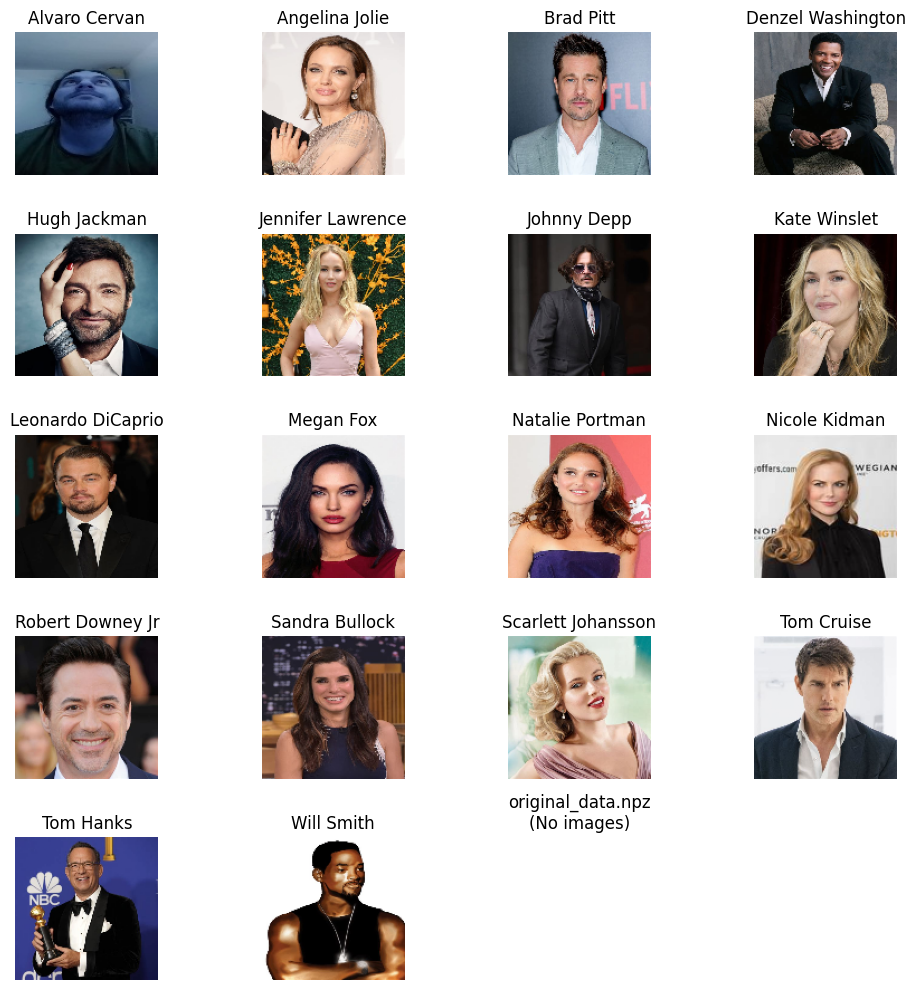

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(len(original_classes)):
    plt.subplot(5, 4, i + 1)
    class_images = original_data[original_labels == i]
    if len(class_images) > 0:
        plt.imshow(class_images[0])
        plt.title(original_classes[i])
        plt.axis("off")
    else:
        plt.title(f"{original_classes[i]}\n(No images)")
        plt.axis("off")
plt.tight_layout()
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Split and prepare data function
def preprocess_and_split(data, labels, num_classes):
    y_cat = to_categorical(labels, num_classes=num_classes)

    # 70% train, 15% validation, 15% test
    X_temp, X_test, y_temp, y_test = train_test_split(
        data, y_cat, test_size=0.15, random_state=42, stratify=y_cat
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
    )  # 0.1765 x 0.85 ≈ 0.15

    return X_train, X_val, X_test, y_train, y_val, y_test

# Prepare original and augmented datasets
original_num_classes = len(original_classes)
augmented_num_classes = len(augmented_classes)

X_train_o, X_val_o, X_test_o, y_train_o, y_val_o, y_test_o = preprocess_and_split(
    original_data, original_labels, num_classes=original_num_classes)

X_train_a, X_val_a, X_test_a, y_train_a, y_val_a, y_test_a = preprocess_and_split(
    augmented_data, augmented_labels, num_classes=augmented_num_classes)

print("✅ Data successfully split: 70% train, 15% val, 15% test")


✅ Data successfully split: 70% train, 15% val, 15% test


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Set mixed precision policy
mixed_precision.set_global_policy('mixed_float16')

def build_vgg16_model(num_classes):
    base = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    base.trainable = False

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax', dtype='float32')(x)  # required for mixed precision

    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Build model for original data
model_o = build_vgg16_model(num_classes=original_num_classes)
model_o.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,850,899 (56.65 MB)

 Trainable params: 136,211 (532.07 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def get_callbacks(model_name="model", models_path="models"):
    checkpoint_path = os.path.join(models_path, f"{model_name}_best.keras")

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    return [early_stop, lr_scheduler, checkpoint]


In [ ]:
def train_model(model, X_train, X_val, y_train, y_val, X_test, y_test, model_name, models_path):
    callbacks = get_callbacks(model_name=model_name, models_path=models_path)
    save_path = os.path.join(models_path, f"{model_name}.keras")

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=callbacks
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

    model.save(save_path)
    print(f"📦 Final model saved to: {save_path}")

    return history


In [ ]:
history_o = train_model(
    model_o,
    X_train_o, X_val_o, y_train_o, y_val_o,
    X_test_o, y_test_o,
    model_name="vgg16_original",
    models_path=models_path
)


Epoch 1/30
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5573 - loss: 1.4342
Epoch 1: val_loss improved from inf to 1.64743, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/models/vgg16_original_best.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5575 - loss: 1.4341 - val_accuracy: 0.4879 - val_loss: 1.6474 - learning_rate: 1.0000e-04
Epoch 2/30
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5519 - loss: 1.4232
Epoch 2: val_loss improved from 1.64743 to 1.64353, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/models/vgg16_original_best.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5522 - loss: 1.4242 - val_accuracy: 0.4909 - val_loss: 1.6435 - learning_rate: 1.0000e-04
Epoch 3/30
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5713 - loss: 1.3928
Epoch 3: val_loss improved from 1.64353 to 1.64127, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/models/vgg16_original_best

In [ ]:
# Build model for augmented dataset
model_a = build_vgg16_model(num_classes=augmented_num_classes)
model_a.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_4 (Cast)                   │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_5 (Cast)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,851,156 (56.65 MB)

 Trainable params: 136,468 (533.08 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Define models path (if not already defined)
models_path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/models"

# Train model using augmented data
history_a = train_model(
    model_a,
    X_train_a, X_val_a, y_train_a, y_val_a,
    X_test_a, y_test_a,
    model_name="vgg16_augmented",
    models_path=models_path
)


Epoch 1/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1076 - loss: 3.0737
Epoch 1: val_loss improved from inf to 2.45999, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/models/vgg16_augmented_best.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 38s 74ms/step - accuracy: 0.1080 - loss: 3.0726 - val_accuracy: 0.2684 - val_loss: 2.4600 - learning_rate: 1.0000e-04
Epoch 2/30
191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2758 - loss: 2.4688
Epoch 2: val_loss improved from 2.45999 to 2.19757, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/models/vgg16_augmented_best.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.2759 - loss: 2.4678 - val_accuracy: 0.3882 - val_loss: 2.1976 - learning_rate: 1.0000e-04
Epoch 3/30
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3229 - loss: 2.2194
Epoch 3: val_loss improved from 2.19757 to 2.02325, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/models/vgg16_

text


In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

def train_custom_vgg16_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, models_path):
    os.makedirs(models_path, exist_ok=True)

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=[early_stop, lr_scheduler]
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ {model_name} Test Accuracy: {test_acc * 100:.2f}%")

    save_path = os.path.join(models_path, f"{model_name}.keras")
    model.save(save_path)
    print(f"📦 Model saved at: {save_path}")

    return model, history


In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

def build_vgg16_functional(num_classes):
    # Input layer
    inputs = Input(shape=(128, 128, 3), name="input_layer")

    # Load VGG16 base
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable = True
    for layer in base_model.layers[:10]:
        layer.trainable = False

    # Custom head
    x = base_model.output
    x = GlobalAveragePooling2D(name="global_average_pooling2d")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)  # Final layer

    # Full model
    model = Model(inputs=inputs, outputs=outputs, name="custom")

    # Compile
    model.compile(
        optimizer=Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model




In [50]:
# For original dataset
model_custom_o = build_vgg16_functional(num_classes=original_num_classes)
model_custom_o.summary()

# For augmented dataset
model_custom_a = build_vgg16_functional(num_classes=augmented_num_classes)
model_custom_a.summary()



Model: "custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_34 (Cast)                  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       131,32

 Total params: 14,853,971 (56.66 MB)

 Trainable params: 13,116,947 (50.04 MB)

 Non-trainable params: 1,737,024 (6.63 MB)

Model: "custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_36 (Cast)                  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │       131,32

 Total params: 14,854,228 (56.66 MB)

 Trainable params: 13,117,204 (50.04 MB)

 Non-trainable params: 1,737,024 (6.63 MB)

In [51]:
model_custom_o, history_custom_o = train_custom_vgg16_model(
    model_custom_o,
    X_train_o, y_train_o,
    X_val_o, y_val_o,
    X_test_o, y_test_o,
    model_name="vgg16_custom_original",
    models_path=models_path
)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - accuracy: 0.2004 - loss: 3.4265 - val_accuracy: 0.2970 - val_loss: 4.2793 - learning_rate: 1.0000e-04
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2698 - loss: 2.6437 - val_accuracy: 0.2515 - val_loss: 4.0604 - learning_rate: 1.0000e-04
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3730 - loss: 2.1678 - val_accuracy: 0.2848 - val_loss: 2.4251 - learning_rate: 1.0000e-04
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4430 - loss: 1.7675 - val_accuracy: 0.3303 - val_loss: 4.2616 - learning_rate: 1.0000e-04
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5592 - loss: 1.4322 - val_accuracy: 0.3818 - val_loss: 2.4821 - learning_rate: 1.0000e-04
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5864 - loss: 1.2570 - val_accuracy: 0.5212 - val_loss: 1.6266 - learning_rate: 1.0000e-04
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.712

In [52]:
model_custom_a, history_custom_a = train_custom_vgg16_model(
    model_custom_a,
    X_train_a, y_train_a,
    X_val_a, y_val_a,
    X_test_a, y_test_a,
    model_name="vgg16_custom_augmented",
    models_path=models_path
)


Epoch 1/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.3330 - loss: 2.4555 - val_accuracy: 0.4716 - val_loss: 1.6933 - learning_rate: 1.0000e-04
Epoch 2/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7417 - loss: 0.8576 - val_accuracy: 0.7710 - val_loss: 0.6791 - learning_rate: 1.0000e-04
Epoch 3/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9167 - loss: 0.2930 - val_accuracy: 0.8658 - val_loss: 0.4292 - learning_rate: 1.0000e-04
Epoch 4/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9476 - loss: 0.2064 - val_accuracy: 0.9583 - val_loss: 0.1573 - learning_rate: 1.0000e-04
Epoch 5/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9805 - loss: 0.0761 - val_accuracy: 0.9727 - val_loss: 0.0929 - learning_rate: 1.0000e-04
Epoch 6/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9918 - loss: 0.0442 - val_accuracy: 0.9818 - val_loss: 0.0656 - learning_rate: 1.0000e-04
Epoch 7/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - a

# New code

### 1. **Preprocessing**
- Face alignment and resizing (to standardize inputs across models)
- Augmentation (optional, to test robustness)
- Train-test split or cross-validation setup

### 2. **Model Selection**
Consider comparing a mix of classical and deep learning-based models:
- **Classical methods**: Eigenfaces, Fisherfaces, LBPH
- **Deep learning**: FaceNet, VGG-Face, ArcFace, Dlib’s CNN, or even pre-trained models from OpenCV and Mediapipe

### 3. **Evaluation Metrics**
Key metrics for assessing performance:
- **Accuracy**: Overall match correctness
- **Precision & Recall**: Particularly if false positives/negatives matter
- **F1 Score**: Balance between precision and recall
- **Inference time**: Speed of recognition per image
- **ROC-AUC**: Especially for threshold-based comparisons

### 4. **Analysis**
- Compare performance per celebrity class (to see if certain faces are harder to identify)
- Analyze confusion matrix for frequent misclassifications
- Try visualizing embeddings (e.g., with t-SNE or PCA)

## Preprocessing

### 1 Install Dependencies and Imports



In [ ]:
!pip install -q mtcnn albumentations==1.4.0 tqdm scikit-learn==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.0 MB/s eta 0:00:00


In [ ]:
import os, cv2, json, math, uuid
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
from mtcnn import MTCNN
import albumentations as A
from sklearn.model_selection import train_test_split

print("TensorFlow", tf.__version__)

TensorFlow 2.18.0


### 2 · Mount Drive & define paths  
Google Drive is mounted, and global constants are declared: raw-data root, processed-data root, manifest location, final image size, augmentation count, and random-seed. Centralizing these paths allows straightforward adaptation to other datasets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

RAW_ROOT  = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Celebrity Faces Dataset"
PROC_ROOT = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces"  # will be created
MANIFEST  = "/content/celebrity_manifest.json"

IMG_SIZE      = (128, 128)   # final size fed to models
AUG_PER_ORIG  = 3            # number of saved variants per original
RANDOM_STATE  = 42


Mounted at /content/drive


### 3 · Helpers (alignment + augmentation)  
`align_crop()` detects the largest face with MTCNN, rotates it until the eyes are horizontal, crops with a margin, resizes to 128 × 128, and outputs RGB. A deterministic list of three Albumentations pipelines—horizontal flip, small rotation, and colour/brightness jitter—specifies the offline augmentations to be saved.

In [ ]:
# ── MTCNN detector
detector = MTCNN()

def align_crop(bgr, out=IMG_SIZE, expand=0.3):
    """
    Detect biggest face, rotate so eyes are horizontal,
    crop with margin, resize→RGB uint8.
    """
    h, w = bgr.shape[:2]
    res  = detector.detect_faces(bgr)

    if res:
        r            = max(res, key=lambda x: x['confidence'])
        x, y, bw, bh = r['box']
        x, y         = max(0, x), max(0, y)
        cx, cy       = x + bw/2, y + bh/2
        side         = max(bw, bh) * (1 + expand)
        x1, y1       = int(cx - side/2), int(cy - side/2)
        x2, y2       = int(cx + side/2), int(cy + side/2)
        x1, y1       = max(0, x1), max(0, y1)
        x2, y2       = min(w, x2), min(h, y2)

        kp           = r['keypoints']
        l_eye, r_eye = kp['left_eye'], kp['right_eye']
        l_eye        = (float(l_eye[0]), float(l_eye[1]))       # cast to Python floats
        angle        = math.degrees(math.atan2(
                           float(r_eye[1]) - l_eye[1],
                           float(r_eye[0]) - l_eye[0]))
        M            = cv2.getRotationMatrix2D(l_eye, angle, 1)
        bgr          = cv2.warpAffine(bgr, M, (w, h))
        crop         = bgr[y1:y2, x1:x2]
    else:                              # fallback: centred square
        side = min(h, w)
        y1, x1 = (h-side)//2, (w-side)//2
        crop = bgr[y1:y1+side, x1:x1+side]

    crop = cv2.resize(crop, out)
    return cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

# ── Deterministic augmentation list (Albumentations)
augmenters = [
    A.Compose([A.HorizontalFlip(p=1.0)], p=1.0),
    A.Compose([A.Rotate(limit=10, border_mode=cv2.BORDER_REFLECT, value=0, p=1.0)], p=1.0),
    A.Compose([A.ColorJitter(brightness=0.2, contrast=0.2,
                             saturation=0.2, hue=0.05, p=1.0)], p=1.0)
]
assert AUG_PER_ORIG <= len(augmenters), "Increase augmenters list or lower AUG_PER_ORIG"


### 4 · Heavy processing loop  
For each raw image, an aligned original and three augmented variants are generated and written to `processed_faces/<class>/`, using UUID stems to avoid collisions. The operation expands the dataset size but is executed only once; later sessions can safely skip this cell.

In [ ]:
if not os.path.exists(PROC_ROOT):
    os.makedirs(PROC_ROOT)

classes = sorted([d for d in os.listdir(RAW_ROOT)
                  if os.path.isdir(os.path.join(RAW_ROOT, d))])

for cls in tqdm(classes, desc="Processing classes"):
    in_dir  = os.path.join(RAW_ROOT,  cls)
    out_dir = os.path.join(PROC_ROOT, cls)
    os.makedirs(out_dir, exist_ok=True)

    for img_path in tqdm(glob(f"{in_dir}/*"), desc=cls, leave=False):
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            continue

        face = align_crop(img_bgr)            # RGB uint8 (aligned)

        base = uuid.uuid4().hex
        # 1️⃣ save aligned original
        cv2.imwrite(f"{out_dir}/{base}_orig.jpg",
                    cv2.cvtColor(face, cv2.COLOR_RGB2BGR))

        # 2️⃣ save deterministic augmentations
        for k, aug in enumerate(augmenters[:AUG_PER_ORIG]):
            aug_face = aug(image=face)["image"]
            cv2.imwrite(f"{out_dir}/{base}_aug{k}.jpg",
                        cv2.cvtColor(aug_face, cv2.COLOR_RGB2BGR))

print("✅  All images processed & saved to", PROC_ROOT)


Processing classes:   0%|          | 0/18 [00:00<?, ?it/s]

Alvaro Cervan:   0%|          | 0/398 [00:00<?, ?it/s]

Angelina Jolie:   0%|          | 0/101 [00:00<?, ?it/s]

Brad Pitt:   0%|          | 0/101 [00:00<?, ?it/s]

Denzel Washington:   0%|          | 0/100 [00:00<?, ?it/s]

Hugh Jackman:   0%|          | 0/101 [00:00<?, ?it/s]

Jennifer Lawrence:   0%|          | 0/100 [00:00<?, ?it/s]

Johnny Depp:   0%|          | 0/101 [00:00<?, ?it/s]

Kate Winslet:   0%|          | 0/101 [00:00<?, ?it/s]

Leonardo DiCaprio:   0%|          | 0/100 [00:00<?, ?it/s]

Megan Fox:   0%|          | 0/101 [00:00<?, ?it/s]

Natalie Portman:   0%|          | 0/101 [00:00<?, ?it/s]

Nicole Kidman:   0%|          | 0/101 [00:00<?, ?it/s]

Robert Downey Jr:   0%|          | 0/100 [00:00<?, ?it/s]

Sandra Bullock:   0%|          | 0/101 [00:00<?, ?it/s]

Scarlett Johansson:   0%|          | 0/200 [00:00<?, ?it/s]

Tom Cruise:   0%|          | 0/101 [00:00<?, ?it/s]

Tom Hanks:   0%|          | 0/101 [00:00<?, ?it/s]

Will Smith:   0%|          | 0/101 [00:00<?, ?it/s]

✅  All images processed & saved to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces


### 5 · Build manifest & stratified split  
All processed JPEGs are enumerated and paired with numeric labels, then a two-stage stratified split (70 % train, 15 % validation, 15 % test) preserves class balance across subsets. File paths and labels are serialized to a JSON manifest for full reproducibility.

In [ ]:
# ── Build stratified 70 / 15 / 15 manifest and save it *inside* processed_faces ─────────
import os, json, numpy as np
from glob import glob
from sklearn.model_selection import train_test_split

# ensure the processed folder exists
os.makedirs(PROC_ROOT, exist_ok=True)

# point the manifest file *into* that folder
MANIFEST = os.path.join(PROC_ROOT, "manifest_70_15_15.json")

valid_exts = ('.jpg', '.jpeg', '.png')
label_map  = {cls: idx for idx, cls in enumerate(classes)}

samples = [
    (p, label_map[cls])
    for cls in classes
    for p in glob(f"{PROC_ROOT}/{cls}/*")
    if p.lower().endswith(valid_exts)
]

paths, labels = zip(*samples)
labels = np.array(labels)

# 70 % train  /  30 % temp
train_idx, tmp_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.30,
    stratify=labels,
    random_state=RANDOM_STATE)

# split temp in half  → 15 % val, 15 % test
val_idx, test_idx = train_test_split(
    tmp_idx,
    test_size=0.50,
    stratify=labels[tmp_idx],
    random_state=RANDOM_STATE)

splits = {k: [samples[i] for i in idx]
          for k, idx in zip(['train', 'val', 'test'],
                            [train_idx, val_idx, test_idx])}

with open(MANIFEST, "w") as f:
    json.dump(splits, f, indent=2)

print(f"📄 Manifest saved ➜ {MANIFEST}")
print(f"{len(train_idx)} train  •  {len(val_idx)} val  •  {len(test_idx)} test images")

NUM_CLASSES = len(classes)


📄 Manifest saved ➜ /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/manifest_70_15_15.json
6151 train  •  1318 val  •  1319 test images


### 6 · `tf.data` loader (no runtime augmentation)  
The loader reads the manifest, shuffles, decodes JPEGs to RGB, casts tensors to `float32` in the `[0, 1]` range, batches, and prefetches. Because augmentations were saved offline, no additional per-batch image transformations are required, ensuring maximum training throughput.

In [ ]:
# ========= tf.data loader (dtype-safe) =========
AUTOTUNE   = tf.data.AUTOTUNE
BATCH_SIZE = 32

def _read_rgb_float32(path):
    """Bytes → BGR → RGB → float32[0,1]."""
    bgr  = cv2.imread(path.decode())
    rgb  = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return (rgb.astype(np.float32) / 255.0)    # <- explicit cast fixes error

def build_dataset(split='train', shuffle=True):
    with open(MANIFEST) as f:
        recs = json.load(f)[split]

    paths  = tf.constant([p for p, _ in recs])
    labels = tf.constant([l for _, l in recs], tf.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
      ds = ds.shuffle(len(recs),               # buffer = full set
                      seed=RANDOM_STATE,
                      reshuffle_each_iteration=False)  # make cardinality finite


    def _load(path, label):
        img = tf.numpy_function(_read_rgb_float32, [path], tf.float32)
        img.set_shape((*IMG_SIZE, 3))
        return img, label

    return ds.map(_load, num_parallel_calls=AUTOTUNE
             ).batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = build_dataset('train')


### 7 · Visual sanity check  
A single batch from `train_ds` is drawn, and sixteen faces are displayed in a 4 × 4 grid alongside their class names. The quick inspection confirms correct alignment, colour channels, and label mapping before any model-training stages commence.

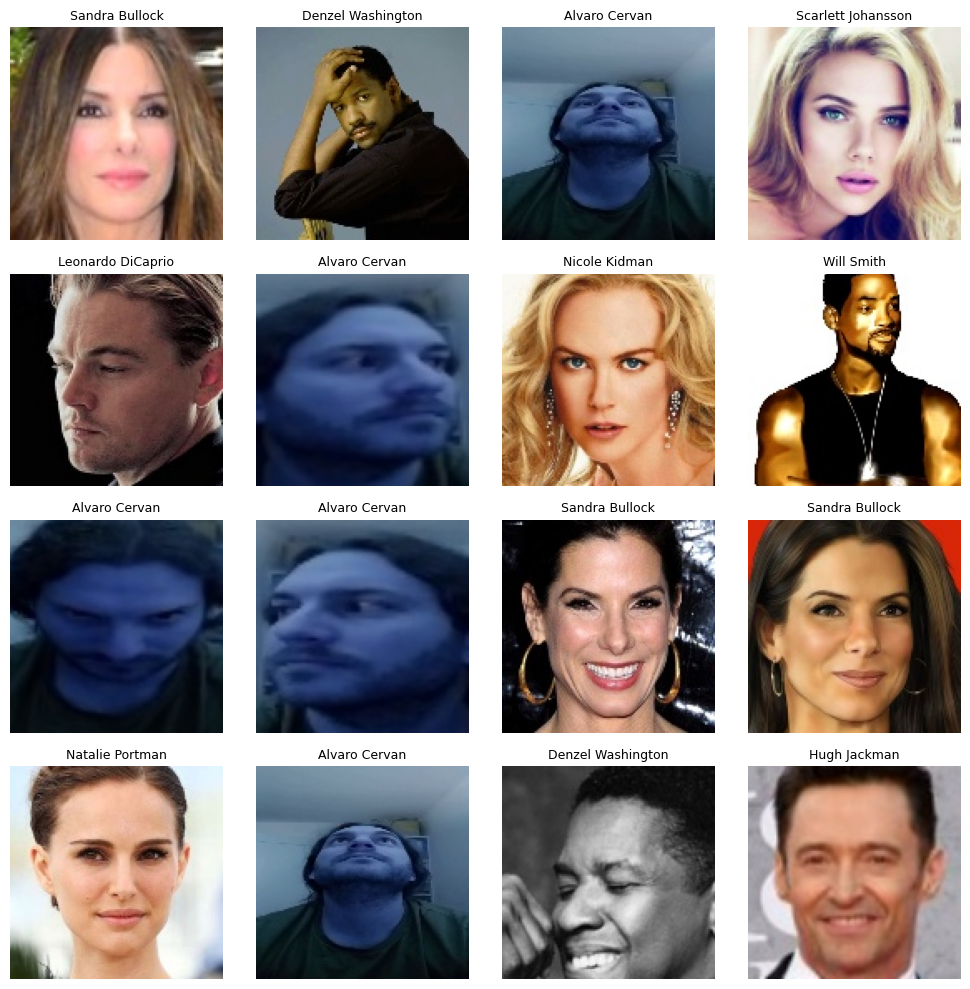

In [ ]:
imgs, lbls = next(iter(train_ds))

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(imgs[i])
    plt.title(classes[int(lbls[i])], fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Train Models

## PCA (Eigenfaces)

original dataset

In [8]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Flatten the image data
X_train_flat = X_train_o.reshape(X_train_o.shape[0], -1)
X_val_flat = X_val_o.reshape(X_val_o.shape[0], -1)
X_test_flat = X_test_o.reshape(X_test_o.shape[0], -1)

# Merge train and val sets
X_classical_train = np.concatenate((X_train_flat, X_val_flat), axis=0)
y_classical_train = np.concatenate((np.argmax(y_train_o, axis=1), np.argmax(y_val_o, axis=1)))
y_classical_test = np.argmax(y_test_o, axis=1)

# Apply PCA
pca = PCA(n_components=100, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_classical_train)
X_test_pca = pca.transform(X_test_flat)

# KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_pca, y_classical_train)

# Evaluate
y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_classical_test, y_pred)
print(f"🔍 PCA + KNN Accuracy: {acc * 100:.2f}%")

# Get unique labels in the test set to pass to classification_report
unique_labels = np.unique(y_classical_test)

print(classification_report(y_classical_test, y_pred, target_names=np.array(original_classes)[unique_labels]))

🔍 PCA + KNN Accuracy: 22.73%
                    precision    recall  f1-score   support

     Alvaro Cervan       0.23      1.00      0.38        60
    Angelina Jolie       0.17      0.07      0.10        15
         Brad Pitt       0.40      0.13      0.20        15
 Denzel Washington       0.10      0.13      0.11        15
      Hugh Jackman       0.00      0.00      0.00        15
 Jennifer Lawrence       0.00      0.00      0.00        15
       Johnny Depp       0.00      0.00      0.00        15
      Kate Winslet       0.50      0.13      0.21        15
 Leonardo DiCaprio       0.00      0.00      0.00        15
         Megan Fox       0.75      0.20      0.32        15
   Natalie Portman       0.00      0.00      0.00        15
     Nicole Kidman       0.50      0.13      0.21        15
  Robert Downey Jr       0.00      0.00      0.00        15
    Sandra Bullock       0.00      0.00      0.00        15
Scarlett Johansson       0.29      0.07      0.11        30
        To

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


augmented dataset

In [9]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Flatten the augmented image data
X_train_flat = X_train_a.reshape(X_train_a.shape[0], -1)
X_val_flat = X_val_a.reshape(X_val_a.shape[0], -1)
X_test_flat = X_test_a.reshape(X_test_a.shape[0], -1)

# Merge train and val sets
X_classical_train = np.concatenate((X_train_flat, X_val_flat), axis=0)
y_classical_train = np.concatenate((np.argmax(y_train_a, axis=1), np.argmax(y_val_a, axis=1)))
y_classical_test = np.argmax(y_test_a, axis=1)

# Apply PCA
pca = PCA(n_components=100, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_classical_train)
X_test_pca = pca.transform(X_test_flat)

# KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_pca, y_classical_train)

# Evaluate
y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_classical_test, y_pred)
print(f"🔍 PCA + KNN (Augmented) Accuracy: {acc * 100:.2f}%")

# Get unique test labels to avoid name mismatch
unique_labels = np.unique(y_classical_test)

print(classification_report(y_classical_test, y_pred, target_names=np.array(augmented_classes)[unique_labels]))


🔍 PCA + KNN (Augmented) Accuracy: 77.18%
                    precision    recall  f1-score   support

     Alvaro Cervan       0.72      1.00      0.84       239
    Angelina Jolie       0.62      0.78      0.69        60
         Brad Pitt       0.64      0.82      0.72        60
 Denzel Washington       0.81      0.77      0.79        60
      Hugh Jackman       0.77      0.67      0.71        60
 Jennifer Lawrence       0.56      0.72      0.63        60
       Johnny Depp       0.95      0.63      0.76        60
      Kate Winslet       0.76      0.73      0.75        60
 Leonardo DiCaprio       0.76      0.70      0.73        60
         Megan Fox       0.88      0.72      0.79        60
   Natalie Portman       0.68      0.70      0.69        60
     Nicole Kidman       0.83      0.80      0.81        60
  Robert Downey Jr       0.97      0.60      0.74        60
    Sandra Bullock       0.87      0.75      0.80        60
Scarlett Johansson       0.92      0.81      0.86       12

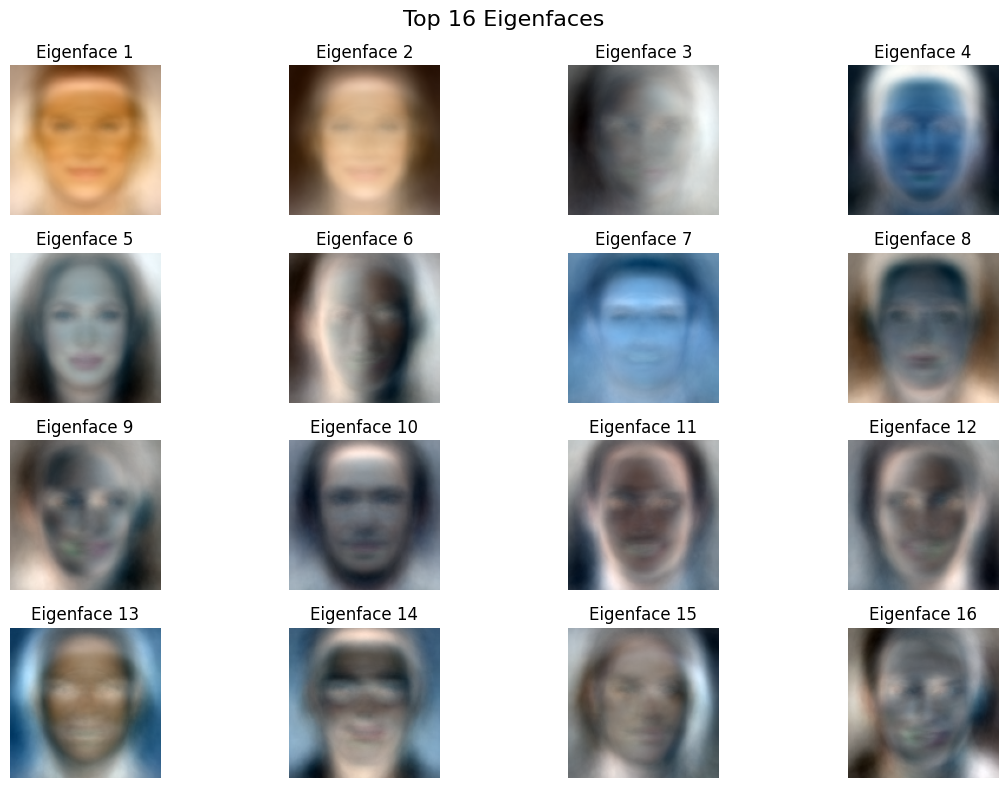

In [13]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Retrieve the eigenfaces (each is a flattened vector)
eigenfaces = pca.components_.reshape((100, 128, 128, 3))  # Shape: (n_components, height, width, channels)

# Plot the top 16 eigenfaces
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Normalize to [0,1] for display using np.ptp
    plt.imshow((eigenfaces[i] - eigenfaces[i].min()) / np.ptp(eigenfaces[i]))
    plt.title(f"Eigenface {i+1}")
    plt.axis("off")

plt.suptitle("Top 16 Eigenfaces", fontsize=16)
plt.tight_layout()
plt.show()

## LPB

In [16]:
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import cv2

# Parameters for LBP
radius = 3
n_points = 8 * radius
method = 'uniform'

# Extract LBP histograms for each image
def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        gray = cv2.cvtColor((img * 255).astype("uint8"), cv2.COLOR_RGB2GRAY)
        lbp = local_binary_pattern(gray, n_points, radius, method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float32")
        hist /= (hist.sum() + 1e-6)  # normalize
        lbp_features.append(hist)
    return np.array(lbp_features)

# Extract features from train, val, test sets
X_train_lbp = extract_lbp_features(X_train_o)
X_val_lbp = extract_lbp_features(X_val_o)
X_test_lbp = extract_lbp_features(X_test_o)

# Merge train and val sets
X_classical_train = np.concatenate((X_train_lbp, X_val_lbp), axis=0)
y_classical_train = np.concatenate((np.argmax(y_train_o, axis=1), np.argmax(y_val_o, axis=1)))
y_classical_test = np.argmax(y_test_o, axis=1)

# Train linear SVM
svm = SVC(kernel='linear')
svm.fit(X_classical_train, y_classical_train)

# Evaluate
y_pred = svm.predict(X_test_lbp)
acc = accuracy_score(y_classical_test, y_pred)
print(f"🔍 LBP + SVM Accuracy: {acc * 100:.2f}%")

# Unique class labels in test set
unique_labels = np.unique(y_classical_test)

print(classification_report(y_classical_test, y_pred, target_names=np.array(original_classes)[unique_labels]))


🔍 LBP + SVM Accuracy: 26.36%
                    precision    recall  f1-score   support

     Alvaro Cervan       0.80      1.00      0.89        60
    Angelina Jolie       0.00      0.00      0.00        15
         Brad Pitt       0.00      0.00      0.00        15
 Denzel Washington       0.00      0.00      0.00        15
      Hugh Jackman       0.00      0.00      0.00        15
 Jennifer Lawrence       0.00      0.00      0.00        15
       Johnny Depp       0.00      0.00      0.00        15
      Kate Winslet       0.00      0.00      0.00        15
 Leonardo DiCaprio       0.00      0.00      0.00        15
         Megan Fox       0.00      0.00      0.00        15
   Natalie Portman       0.00      0.00      0.00        15
     Nicole Kidman       0.00      0.00      0.00        15
  Robert Downey Jr       0.00      0.00      0.00        15
    Sandra Bullock       0.00      0.00      0.00        15
Scarlett Johansson       0.11      0.90      0.19        30
        To

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import cv2

# Parameters for LBP
radius = 3
n_points = 8 * radius
method = 'uniform'

# LBP feature extractor
def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        gray = cv2.cvtColor((img * 255).astype("uint8"), cv2.COLOR_RGB2GRAY)
        lbp = local_binary_pattern(gray, n_points, radius, method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float32")
        hist /= (hist.sum() + 1e-6)
        lbp_features.append(hist)
    return np.array(lbp_features)

# Extract features from augmented split
X_train_lbp = extract_lbp_features(X_train_a)
X_val_lbp = extract_lbp_features(X_val_a)
X_test_lbp = extract_lbp_features(X_test_a)

# Merge train + val
X_classical_train = np.concatenate((X_train_lbp, X_val_lbp), axis=0)
y_classical_train = np.concatenate((np.argmax(y_train_a, axis=1), np.argmax(y_val_a, axis=1)))
y_classical_test = np.argmax(y_test_a, axis=1)

# Train SVM
svm = SVC(kernel='linear')
svm.fit(X_classical_train, y_classical_train)

# Evaluate
y_pred = svm.predict(X_test_lbp)
acc = accuracy_score(y_classical_test, y_pred)
print(f"🔍 LBP + SVM (Augmented) Accuracy: {acc * 100:.2f}%")

# Display metrics
unique_labels = np.unique(y_classical_test)
print(classification_report(y_classical_test, y_pred, target_names=np.array(augmented_classes)[unique_labels]))


🔍 LBP + SVM (Augmented) Accuracy: 25.55%
                    precision    recall  f1-score   support

     Alvaro Cervan       0.74      0.97      0.84       239
    Angelina Jolie       0.00      0.00      0.00        60
         Brad Pitt       0.00      0.00      0.00        60
 Denzel Washington       0.00      0.00      0.00        60
      Hugh Jackman       0.00      0.00      0.00        60
 Jennifer Lawrence       0.00      0.00      0.00        60
       Johnny Depp       0.00      0.00      0.00        60
      Kate Winslet       0.00      0.00      0.00        60
 Leonardo DiCaprio       0.00      0.00      0.00        60
         Megan Fox       0.00      0.00      0.00        60
   Natalie Portman       0.00      0.00      0.00        60
     Nicole Kidman       0.00      0.00      0.00        60
  Robert Downey Jr       0.00      0.00      0.00        60
    Sandra Bullock       0.00      0.00      0.00        60
Scarlett Johansson       0.10      0.88      0.19       12

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Paths created during preprocessing
PROC_ROOT  = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces"
MANIFEST   = "/content/celebrity_manifest.json"
IMG_SIZE   = (128, 128)
RANDOM_STATE = 42


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, json, cv2, numpy as np, tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split

# discover classes directly from processed folder
classes     = sorted([d for d in os.listdir(PROC_ROOT)
                      if os.path.isdir(os.path.join(PROC_ROOT, d))])
label_map   = {cls: idx for idx, cls in enumerate(classes)}
NUM_CLASSES = len(classes)

print("Classes:", classes)


Classes: ['Alvaro Cervan', 'Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


In [ ]:
# ── Fast tf.data loader (dtype-safe, manifest inside processed_faces) ───────
# Manifest now lives in the processed-faces directory
MANIFEST = os.path.join(PROC_ROOT, "manifest_70_15_15.json")
assert os.path.exists(MANIFEST), "Manifest file not found—run the split cell first."

AUTOTUNE   = tf.data.AUTOTUNE
BATCH_SIZE = 32

def _read_rgb_float32(path):
    """bytes → RGB float32 tensor ∈ [0, 1]."""
    bgr  = cv2.imread(path.decode())
    rgb  = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb.astype(np.float32) / 255.0

def build_dataset(split="train", shuffle=True):
    # load the list of (filepath, label) tuples
    with open(MANIFEST) as f:
        recs = json.load(f)[split]

    paths  = tf.constant([p for p, _ in recs])
    labels = tf.constant([l for _, l in recs], tf.int32)  # sparse labels

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
      ds = ds.shuffle(len(recs),               # buffer = full set
                      seed=RANDOM_STATE,
                      reshuffle_each_iteration=False)  # make cardinality finite


    def _load(path, label):
        img = tf.numpy_function(_read_rgb_float32, [path], tf.float32)
        img.set_shape((*IMG_SIZE, 3))
        return img, label

    return (ds.map(_load, num_parallel_calls=AUTOTUNE)
              .batch(BATCH_SIZE)
              .prefetch(AUTOTUNE))

# build once
train_ds = build_dataset("train")
val_ds   = build_dataset("val")
test_ds  = build_dataset("test", shuffle=False)

# quick sanity print
print("train batches:", len(train_ds),
      "| val batches:", len(val_ds),
      "| test batches:", len(test_ds))


train batches: 193 | val batches: 42 | test batches: 42


### MovileNetV2

In [ ]:
import tensorflow as tf, os
from tensorflow.keras import mixed_precision, callbacks
from tensorflow.keras.optimizers import Adam

mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)                 # XLA fusion


In [ ]:
def build_dataset(split="train", shuffle=True):
    with open(MANIFEST) as f:
        recs = json.load(f)[split]

    paths  = tf.constant([p for p, _ in recs])
    labels = tf.constant([l for _, l in recs], tf.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(recs),
                        seed=RANDOM_STATE,
                        reshuffle_each_iteration=False)

    def _load(path, label):
        img = tf.numpy_function(_read_rgb_float32, [path], tf.float32)
        img.set_shape((*IMG_SIZE, 3))
        return img, label

    return (ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
              .cache()                # <── images kept in RAM ⬆️⬆️
              .batch(BATCH_SIZE)
              .prefetch(tf.data.AUTOTUNE))

train_ds = build_dataset("train")
val_ds   = build_dataset("val")
test_ds  = build_dataset("test", shuffle=False)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers       import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models       import Model

mb_base = MobileNetV2(include_top=False,
                      alpha=0.35,            # width multiplier → super small
                      weights="imagenet",
                      input_shape=(*IMG_SIZE, 3))
mb_base.trainable = False                    # freeze encoder

x = GlobalAveragePooling2D()(mb_base.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

model = Model(mb_base.input, out)
model.summary(line_length=110)


2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape              ┃          Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)     │ (None, 128, 128, 3)       │                0 │ -                          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ cast_6 (Cast)                  │ (None, 128, 128, 3)       │                0 │ input_layer_3[0][0]        │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                 │ (None, 64, 64, 16)        │              432 │ cast_6[0][0]               │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization)  │ (None, 64, 64, 16)        │               64 │ Conv1[0][0]                │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)              │ (None, 64, 64, 16)        │                0 │ bn_Conv1[0][0]             │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ expanded_conv_depthwise        │ (None, 64, 64, 16)        │              144 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)              │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN     │ (None, 64, 64, 16)        │               64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu   │ (None, 64, 64, 16)        │                0 │ expanded_conv_depthwise_B… │
│ (ReLU)                         │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ expanded_conv_project (Conv2D) │ (None, 64, 64, 8)         │              128 │ expanded_conv_depthwise_r… │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ expanded_conv_project_BN       │ (None, 64, 64, 8)         │               32 │ expanded_conv_project[0][… │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)        │ (None, 64, 64, 48)        │              384 │ expanded_conv_project_BN[… │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ block_1_expand_BN              │ (None, 64, 64, 48)        │              192 │ block_1_expand[0][0]       │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)     │ (None, 64, 64, 48)        │                0 │ block_1_expand_BN[0][0]    │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)    │ (None, 65, 65, 48)        │                0 │ block_1_expand_relu[0][0]  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ bl

 Total params: 576,498 (2.20 MB)

 Trainable params: 166,290 (649.57 KB)

 Non-trainable params: 410,208 (1.56 MB)

In [ ]:
opt = mixed_precision.LossScaleOptimizer(Adam(3e-4))   # higher LR for small net

model.compile(optimizer   = opt,
              loss        = "sparse_categorical_crossentropy",
              metrics     = ["accuracy"],
              jit_compile = True)


In [ ]:
CKPT_PATH = os.path.join(PROC_ROOT, "mbv2_fast_best.h5")

cb = [
    callbacks.EarlyStopping(monitor="val_accuracy",
                            patience=4,
                            restore_best_weights=True),
    callbacks.ModelCheckpoint(CKPT_PATH,
                              monitor="val_accuracy",
                              save_best_only=True,
                              verbose=1)
]


In [ ]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs          = 30,
    callbacks       = cb,
    verbose         = 1
)


Epoch 1/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3073 - loss: 2.2962
Epoch 1: val_accuracy improved from -inf to 0.60774, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 920s 5s/step - accuracy: 0.3078 - loss: 2.2942 - val_accuracy: 0.6077 - val_loss: 1.3521
Epoch 2/30
188/193 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5733 - loss: 1.3373
Epoch 2: val_accuracy improved from 0.60774 to 0.70941, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5744 - loss: 1.3340 - val_accuracy: 0.7094 - val_loss: 0.9978
Epoch 3/30
189/193 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6871 - loss: 0.9888
Epoch 3: val_accuracy improved from 0.70941 to 0.77086, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6877 - loss: 0.9874 - val_accuracy: 0.7709 - val_loss: 0.7996
Epoch 4/30
191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7542 - loss: 0.7938
Epoch 4: val_accuracy improved from 0.77086 to 0.80121, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7543 - loss: 0.7933 - val_accuracy: 0.8012 - val_loss: 0.6801
Epoch 5/30
188/193 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7992 - loss: 0.6592
Epoch 5: val_accuracy improved from 0.80121 to 0.82322, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7994 - loss: 0.6588 - val_accuracy: 0.8232 - val_loss: 0.5955
Epoch 6/30
191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8272 - loss: 0.5658
Epoch 6: val_accuracy improved from 0.82322 to 0.84294, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8273 - loss: 0.5655 - val_accuracy: 0.8429 - val_loss: 0.5289
Epoch 7/30
189/193 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8560 - loss: 0.4906
Epoch 7: val_accuracy improved from 0.84294 to 0.85812, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8560 - loss: 0.4903 - val_accuracy: 0.8581 - val_loss: 0.4706
Epoch 8/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8796 - loss: 0.4234
Epoch 8: val_accuracy improved from 0.85812 to 0.87557, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8796 - loss: 0.4234 - val_accuracy: 0.8756 - val_loss: 0.4184
Epoch 9/30
189/193 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9018 - loss: 0.3728
Epoch 9: val_accuracy improved from 0.87557 to 0.88543, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9018 - loss: 0.3725 - val_accuracy: 0.8854 - val_loss: 0.3870
Epoch 10/30
188/193 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9081 - loss: 0.3410
Epoch 10: val_accuracy improved from 0.88543 to 0.89681, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9082 - loss: 0.3407 - val_accuracy: 0.8968 - val_loss: 0.3557
Epoch 11/30
188/193 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9238 - loss: 0.2939
Epoch 11: val_accuracy improved from 0.89681 to 0.89985, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9238 - loss: 0.2938 - val_accuracy: 0.8998 - val_loss: 0.3311
Epoch 12/30
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9358 - loss: 0.2720
Epoch 12: val_accuracy improved from 0.89985 to 0.90744, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9358 - loss: 0.2720 - val_accuracy: 0.9074 - val_loss: 0.3100
Epoch 13/30
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9393 - loss: 0.2329
Epoch 13: val_accuracy improved from 0.90744 to 0.91502, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9393 - loss: 0.2330 - val_accuracy: 0.9150 - val_loss: 0.2902
Epoch 14/30
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9436 - loss: 0.2279
Epoch 14: val_accuracy improved from 0.91502 to 0.91654, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9437 - loss: 0.2277 - val_accuracy: 0.9165 - val_loss: 0.2717
Epoch 15/30
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9569 - loss: 0.1957
Epoch 15: val_accuracy improved from 0.91654 to 0.91806, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9568 - loss: 0.1958 - val_accuracy: 0.9181 - val_loss: 0.2585
Epoch 16/30
188/193 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9537 - loss: 0.1825
Epoch 16: val_accuracy improved from 0.91806 to 0.92109, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9537 - loss: 0.1825 - val_accuracy: 0.9211 - val_loss: 0.2432
Epoch 17/30
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9626 - loss: 0.1602
Epoch 17: val_accuracy improved from 0.92109 to 0.93020, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9627 - loss: 0.1600 - val_accuracy: 0.9302 - val_loss: 0.2273
Epoch 18/30
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9647 - loss: 0.1482
Epoch 18: val_accuracy improved from 0.93020 to 0.93323, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9648 - loss: 0.1482 - val_accuracy: 0.9332 - val_loss: 0.2195
Epoch 19/30
191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9707 - loss: 0.1383
Epoch 19: val_accuracy improved from 0.93323 to 0.93703, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9707 - loss: 0.1383 - val_accuracy: 0.9370 - val_loss: 0.2083
Epoch 20/30
190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9713 - loss: 0.1254
Epoch 20: val_accuracy improved from 0.93703 to 0.94310, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9713 - loss: 0.1254 - val_accuracy: 0.9431 - val_loss: 0.1921
Epoch 21/30
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9754 - loss: 0.1138
Epoch 21: val_accuracy improved from 0.94310 to 0.94841, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9754 - loss: 0.1138 - val_accuracy: 0.9484 - val_loss: 0.1822
Epoch 22/30
191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9801 - loss: 0.1032
Epoch 22: val_accuracy did not improve from 0.94841
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9801 - loss: 0.1032 - val_accuracy: 0.9476 - val_loss: 0.1740
Epoch 23/30
189/193 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9809 - loss: 0.0985
Epoch 23: val_accuracy improved from 0.94841 to 0.95068, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9809 - loss: 0.0985 - val_accuracy: 0.9507 - val_loss: 0.1714
Epoch 24/30
191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9853 - loss: 0.0847
Epoch 24: val_accuracy did not improve from 0.95068
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9852 - loss: 0.0848 - val_accuracy: 0.9484 - val_loss: 0.1640
Epoch 25/30
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9861 - loss: 0.0779
Epoch 25: val_accuracy improved from 0.95068 to 0.95220, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9861 - loss: 0.0779 - val_accuracy: 0.9522 - val_loss: 0.1664
Epoch 26/30
187/193 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9837 - loss: 0.0838
Epoch 26: val_accuracy did not improve from 0.95220
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9837 - loss: 0.0837 - val_accuracy: 0.9522 - val_loss: 0.1569
Epoch 27/30
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9861 - loss: 0.0672
Epoch 27: val_accuracy improved from 0.95220 to 0.95675, saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_best.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9861 - loss: 0.0672 - val_accuracy: 0.9568 - val_loss: 0.1521
Epoch 28/30
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9882 - loss: 0.0638
Epoch 28: val_accuracy did not improve from 0.95675
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9881 - loss: 0.0639 - val_accuracy: 0.9560 - val_loss: 0.1546
Epoch 29/30
187/193 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9929 - loss: 0.0558
Epoch 29: val_accuracy did not improve from 0.95675
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9928 - loss: 0.0559 - val_accuracy: 0.9568 - val_loss: 0.1481
Epoch 30/30
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9904 - loss: 0.0567
Epoch 30: val_accuracy did not improve from 0.95675
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9904 - loss: 0.0567 - val_accuracy: 0.9568 - val_loss: 0.1394


In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\n✅ MobileNetV2-0.35 Test Accuracy: {test_acc*100:.2f}%")


model.save('/content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_final.h5')
print("Model saved ➜", FINAL_PATH)



✅ MobileNetV2-0.35 Test Accuracy: 95.38%
Model saved ➜ /content/drive/MyDrive/Colab Notebooks/Computer Vision/processed_faces/mbv2_fast_final.h5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# directory that already contains class sub-folders of aligned faces
PROC_ROOT  = "/content/drive/MyDrive/Colab Notebooks/Computer Vision"

# manifest you saved earlier
MANIFEST   = f"{PROC_ROOT}/processed_faces/manifest_70_15_15.json"

# where the TFRecord will live
TFREC_DIR  = f"{PROC_ROOT}/tfrecords"
TFREC_FILE = f"{TFREC_DIR}/faces.tfrecord"

IMG_SIZE       = (128, 128)
BATCH_SIZE     = 32
RANDOM_STATE   = 42


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ── JPEG → TFRecord (run only if the record is absent) ──────────────────────
import os, json, cv2, tensorflow as tf
from tqdm import tqdm

os.makedirs(TFREC_DIR, exist_ok=True)

if os.path.exists(TFREC_FILE):
    print("🟢 TFRecord already present ➜", TFREC_FILE)
else:
    print("⚙️  Converting JPEGs to TFRecord …")

    def _bytes(v): return tf.train.Feature(bytes_list=tf.train.BytesList(value=[v]))
    def _int(v):   return tf.train.Feature(int64_list=tf.train.Int64List(value=[v]))

    # read manifest once
    with open(MANIFEST) as f:
        splits = json.load(f)
    recs = splits["train"] + splits["val"] + splits["test"]

    writer = tf.io.TFRecordWriter(TFREC_FILE)

    for path, label in tqdm(recs, desc="Serialising"):
        rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)   # H×W×3 uint8
        ex  = tf.train.Example(features=tf.train.Features(feature={
            "size" : _int(rgb.shape[0]),                         # height (square)
            "label": _int(label),
            "img"  : _bytes(rgb.tobytes())
        }))
        writer.write(ex.SerializeToString())

    writer.close()
    print("✅ TFRecord saved ➜", TFREC_FILE)


🟢 TFRecord already present ➜ /content/drive/MyDrive/Colab Notebooks/Computer Vision/tfrecords/faces.tfrecord


#VGG16 TRFConversion

In [ ]:
# ── Minimal VGG-16 transfer-learning on the new tf.data splits ──────────────
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers       import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models       import Model
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")      # keep FP16 speed-up
tf.config.optimizer.set_jit(True)                       # XLA compile

# NUM_CLASSES was inferred earlier from the manifest
vgg_base = VGG16(include_top=False,
                 weights="imagenet",
                 input_shape=(*IMG_SIZE, 3))
vgg_base.trainable = False                              # freeze backbone

x   = GlobalAveragePooling2D()(vgg_base.output)
x   = Dense(256, activation="relu")(x)
x   = Dropout(0.5)(x)
out = Dense(NUM_CLASSES, activation="softmax",
            dtype="float32")(x)                         # logits FP32

model = Model(vgg_base.input, out)

model.compile(optimizer = Adam(1e-4),
              loss      = "sparse_categorical_crossentropy",  # integer labels
              metrics   = ["accuracy"],
              jit_compile = True)

# train_ds, val_ds, test_ds already come from the TFRecord pipeline
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs          = 30,
                    batch_size      = 32)

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

model.save("/content/drive/MyDrive/Colab Notebooks/Computer Vision/models/vgg16_face_classifier.h5")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
    193/Unknown 20s 30ms/step - accuracy: 0.1175 - loss: 3.0101

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.1178 - loss: 3.0090 - val_accuracy: 0.2504 - val_loss: 2.4218
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2749 - loss: 2.4371

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.2749 - loss: 2.4368 - val_accuracy: 0.3543 - val_loss: 2.1932
Epoch 3/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3206 - loss: 2.2207

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.3208 - loss: 2.2200 - val_accuracy: 0.4120 - val_loss: 2.0440
Epoch 4/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3628 - loss: 2.0757

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3629 - loss: 2.0755 - val_accuracy: 0.4545 - val_loss: 1.9285
Epoch 5/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3998 - loss: 1.9526

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.3999 - loss: 1.9521 - val_accuracy: 0.5076 - val_loss: 1.8267
Epoch 6/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4238 - loss: 1.8708

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4238 - loss: 1.8704 - val_accuracy: 0.5432 - val_loss: 1.7408
Epoch 7/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4471 - loss: 1.7925

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4473 - loss: 1.7921 - val_accuracy: 0.5630 - val_loss: 1.6653
Epoch 8/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4652 - loss: 1.7198

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4653 - loss: 1.7197 - val_accuracy: 0.5812 - val_loss: 1.6006
Epoch 9/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4852 - loss: 1.6532

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4853 - loss: 1.6529 - val_accuracy: 0.5880 - val_loss: 1.5447
Epoch 10/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4966 - loss: 1.6075

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4968 - loss: 1.6070 - val_accuracy: 0.6047 - val_loss: 1.4921
Epoch 11/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5059 - loss: 1.5691

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5060 - loss: 1.5689 - val_accuracy: 0.6146 - val_loss: 1.4451
Epoch 12/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5402 - loss: 1.4982

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5402 - loss: 1.4982 - val_accuracy: 0.6290 - val_loss: 1.3998
Epoch 13/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5484 - loss: 1.4598

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5485 - loss: 1.4596 - val_accuracy: 0.6411 - val_loss: 1.3610
Epoch 14/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5630 - loss: 1.4126

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5631 - loss: 1.4125 - val_accuracy: 0.6525 - val_loss: 1.3237
Epoch 15/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5663 - loss: 1.4011

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5665 - loss: 1.4009 - val_accuracy: 0.6624 - val_loss: 1.2904
Epoch 16/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5731 - loss: 1.3615

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5732 - loss: 1.3613 - val_accuracy: 0.6700 - val_loss: 1.2580
Epoch 17/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5862 - loss: 1.3240

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5864 - loss: 1.3238 - val_accuracy: 0.6745 - val_loss: 1.2251
Epoch 18/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5917 - loss: 1.2996

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5918 - loss: 1.2994 - val_accuracy: 0.6859 - val_loss: 1.1993
Epoch 19/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6091 - loss: 1.2656

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6092 - loss: 1.2656 - val_accuracy: 0.6904 - val_loss: 1.1726
Epoch 20/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6342 - loss: 1.2260

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6342 - loss: 1.2257 - val_accuracy: 0.6889 - val_loss: 1.1464
Epoch 21/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6249 - loss: 1.2163

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.6250 - loss: 1.2161 - val_accuracy: 0.7003 - val_loss: 1.1211
Epoch 22/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6232 - loss: 1.2004

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6233 - loss: 1.2001 - val_accuracy: 0.7056 - val_loss: 1.0979
Epoch 23/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6479 - loss: 1.1696

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6479 - loss: 1.1693 - val_accuracy: 0.7162 - val_loss: 1.0749
Epoch 24/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6490 - loss: 1.1440

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6491 - loss: 1.1438 - val_accuracy: 0.7162 - val_loss: 1.0527
Epoch 25/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


190/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6618 - loss: 1.1150

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6618 - loss: 1.1146 - val_accuracy: 0.7284 - val_loss: 1.0311
Epoch 26/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6756 - loss: 1.0912

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.6756 - loss: 1.0910 - val_accuracy: 0.7299 - val_loss: 1.0112
Epoch 27/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6598 - loss: 1.0963

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6599 - loss: 1.0959 - val_accuracy: 0.7344 - val_loss: 0.9943
Epoch 28/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6678 - loss: 1.0667

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6680 - loss: 1.0663 - val_accuracy: 0.7360 - val_loss: 0.9756
Epoch 29/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6786 - loss: 1.0419

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.6787 - loss: 1.0416 - val_accuracy: 0.7420 - val_loss: 0.9591
Epoch 30/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


191/193 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6889 - loss: 1.0205

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6890 - loss: 1.0203 - val_accuracy: 0.7504 - val_loss: 0.9420


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



✅ Test Accuracy: 73.46%


In [ ]:
# ── keep ONE copy of this cell ──────────────────────────────────────────────
AUTOTUNE   = tf.data.AUTOTUNE
BATCH_SIZE = 32

with open(MANIFEST) as f:
    counts = {k: len(v) for k, v in json.load(f).items()}

ranges, start = {}, 0
for k in ["train", "val", "test"]:
    ranges[k] = (start, start + counts[k])
    start    += counts[k]

def _parse(proto):
    fspec = {
        "size" : tf.io.FixedLenFeature([], tf.int64),
        "label": tf.io.FixedLenFeature([], tf.int64),
        "img"  : tf.io.FixedLenFeature([], tf.string)
    }
    ex   = tf.io.parse_single_example(proto, fspec)
    h    = ex["size"]
    img  = tf.io.decode_raw(ex["img"], tf.uint8)
    img  = tf.reshape(img, (h, h, 3))
    img  = tf.cast(img, tf.float32) / 255.0
    return img, ex["label"]

def build_ds(split):
    begin, end = ranges[split]
    return (tf.data.TFRecordDataset(TFREC_FILE)
              .skip(begin).take(end - begin)
              .shuffle(end - begin,
                       seed=RANDOM_STATE,
                       reshuffle_each_iteration=False)   # finite
              .map(_parse, num_parallel_calls=AUTOTUNE)
              .batch(BATCH_SIZE)
              .prefetch(AUTOTUNE))

train_ds = build_ds("train")
val_ds   = build_ds("val")
test_ds  = build_ds("test", )

print("Batches ➜",
      len(train_ds), "train |",
      len(val_ds),   "val |",
      len(test_ds),  "test")


TypeError: The dataset length is unknown.

In [ ]:
# ────────────────────────────────────────────────────────────────────────────
# TFRecord → tf.data loader  (one copy, finite, prints batch counts safely)
# ────────────────────────────────────────────────────────────────────────────
import tensorflow as tf, json, os

# Paths / constants ----------------------------------------------------------
AUTOTUNE    = tf.data.AUTOTUNE
BATCH_SIZE  = 32
RANDOM_SEED = 42

# ---------------------------------------------------------------------------

# 1. Read split sizes once
with open(MANIFEST) as f:
    counts = {k: len(v) for k, v in json.load(f).items()}

# 2. Compute index ranges for skip/take
ranges, start = {}, 0
for k in ["train", "val", "test"]:
    ranges[k] = (start, start + counts[k])
    start    += counts[k]

# 3. TFRecord → tensor parser
def _parse(proto):
    fspec = {
        "size" : tf.io.FixedLenFeature([], tf.int64),
        "label": tf.io.FixedLenFeature([], tf.int64),
        "img"  : tf.io.FixedLenFeature([], tf.string)
    }
    ex   = tf.io.parse_single_example(proto, fspec)
    h    = ex["size"]
    img  = tf.io.decode_raw(ex["img"], tf.uint8)
    img  = tf.reshape(img, (h, h, 3))
    img  = tf.cast(img, tf.float32) / 255.0         # [0,1]
    return img, ex["label"]

# 4. Dataset builder
def build_ds(split):
    begin, end = ranges[split]
    return (tf.data.TFRecordDataset(TFREC_FILE)
              .skip(begin).take(end - begin)                  # slice the TFRecord
              .shuffle(end - begin,
                       seed=RANDOM_SEED,
                       reshuffle_each_iteration=False)        # finite cardinality
              .map(_parse, num_parallel_calls=AUTOTUNE)
              .batch(BATCH_SIZE)
              .prefetch(AUTOTUNE))

# 5. Build the three splits
train_ds = build_ds("train")
val_ds   = build_ds("val")
test_ds  = build_ds("test")

# 6. Compute batch counts directly from the manifest
train_batches = (counts["train"] + BATCH_SIZE - 1) // BATCH_SIZE
val_batches   = (counts["val"]   + BATCH_SIZE - 1) // BATCH_SIZE
test_batches  = (counts["test"]  + BATCH_SIZE - 1) // BATCH_SIZE

print("Batches ➜",
      train_batches, "train |",
      val_batches,   "val |",
      test_batches,  "test")